# Accessing cloud satellite data

- Funding: Interagency Implementation and Advanced Concepts Team [IMPACT](https://earthdata.nasa.gov/esds/impact) for the Earth Science Data Systems (ESDS) program and AWS Public Dataset Program
  
### Credits: Tutorial development
* [Dr. Chelle Gentemann](mailto:gentemann@faralloninstitute.org) -  [Twitter](https://twitter.com/ChelleGentemann)   - Farallon Institute
* [Lucas Sterzinger](mailto:lsterzinger@ucdavis.edu) - [Twitter](https://twitter.com/lucassterzinger) - University of California, Davis


### Satellite data

Satellite data come from either polar or low inclination orbits that circle the Earth or geostationary orbits that hold a location above a specific location on the Earth, near the Equator.  The type of data from satellites depends on both the orbit and the type of instrument.  There are definitions for the different satellite data types.
- L1 - satellite observations, usually each observation has a lat/lon/time associated with it
- L2 - derived geophysical retrievals (eg. SST), still with lat/lon/time
- L3 - variables mapped to a uniform space/time grid
- L4 - model output or analysis of data, may include multiple sensors

There are several different formats that satellite data:  [netCDF](https://www.unidata.ucar.edu/software/netcdf/), [HDF5](https://www.hdfgroup.org/solutions/hdf5/), and [geoTIFF](https://earthdata.nasa.gov/esdis/eso/standards-and-references/geotiff).
There are also som newer cloud optimized formats that data: [Zarr](https://zarr.readthedocs.io/en/stable/), Cloud Optimized GeoTIFF ([COG](https://www.cogeo.org/)).

### Understand the data
Data access can be easy and fast on the cloud, but to avoid potential issues down the road, spend time to understand the strengths and weaknesses of any data.  Any science results will need to address uncertainties in the data, so it is easier to spend time at the beginning to understand them and avoid data mis-application.

#### This tutorial will focus on netCDF/HDF5/Zarr

### Data proximate computing
These are BIG datasets that you can analyze on the cloud without downloading the data.  
You can run this on your phone, a Raspberry Pi, laptop, or desktop.   
By using public cloud data, your science is reproducible and easily shared!

The OHW Jupyter Hub is a m5.2xlarge instance shared by up to 4 users.  What does that mean?  [m5.2xlarge](https://aws.amazon.com/ec2/instance-types/m5/) has 8 vCPU and 32 GB memory.
If there are 3 other users on your node, then the memory could be used up fast by large satellite datasets, so just be a little aware of that when you want to run something....

### Here we will demonstrate some ways to access the different SST datasets on AWS:
- AWS MUR sea surface temperatures  (L4)
- AWS GOES sea surface temperatures  (L2)
- AWS Himawari sea surface temperatures (L2 and L3)
- ERA5 data (L4)

### To run this notebook

Code is in the cells that have <span style="color: blue;">In [  ]:</span> to the left of the cell and have a colored background

To run the code:
- option 1) click anywhere in the cell, then hold `shift` down and press `Enter`
- option 2) click on the Run button at the top of the page in the dashboard

Remember:
- to insert a new cell below press `Esc` then `b`
- to delete a cell press `Esc` then `dd`

### First start by importing libraries


# How to find an AWS Public Dataset

- Click here: [AWS Public Dataset](https://aws.amazon.com/opendata/)




-------------------------------------------------------





- Click on `Find public available data on AWS` button
- Search for MUR
- Select [MUR SST](https://registry.opendata.aws/mur/)

 
 
 
 

-------------------------------------------------------

![](./awsmur.png)










## [MUR SST](https://podaac.jpl.nasa.gov/Multi-scale_Ultra-high_Resolution_MUR-SST) [AWS Public dataset program](https://registry.opendata.aws/mur/) 

### Access the MUR SST Zarr store which is in an s3 bucket.  

![image](https://podaac.jpl.nasa.gov/Podaac/thumbnails/MUR-JPL-L4-GLOB-v4.1.jpg)

We will start with my favorite Analysis Ready Data (ARD) format: [Zarr](https://zarr.readthedocs.io/en/stable/).  Using data stored in Zarr is fast, simple, and contains all the metadata normally in a netcdf file, so you can figure out easily what is in the datastore.  

- Fast - Zarr is fast because all the metadata is consolidated into a .json file.  Reading in massive datasets is lightning fast because it only reads the metadata and does read in data until it needs it for compute.

- Simple - Filenames?  Who needs them? Who cares?  Not I.  Simply point your read routine to the data directory.

- Metadata - all you want!

In [1]:
# filter some warning messages
import warnings 
warnings.filterwarnings("ignore") 

#libraries
import datetime as dt
import xarray as xr
import fsspec
import s3fs
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
# make datasets display nicely
xr.set_options(display_style="html")  

import dask
from dask.distributed import performance_report, Client, progress

#magic fncts #put static images of your plot embedded in the notebook
%matplotlib inline  
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 


[fsspec.get_mapper](https://filesystem-spec.readthedocs.io/en/latest/api.html?highlight=get_mapper#fsspec.get_mapper) Creates a mapping between your computer and the s3 bucket.  This isn't necessary if the Zarr file is stored locally.

[xr.open_zarr](http://xarray.pydata.org/en/stable/generated/xarray.open_zarr.html) Reads a Zarr store into an Xarray dataset


In [2]:
%%time
file_location = 's3://mur-sst/zarr'

ikey = fsspec.get_mapper(file_location, anon=True)

ds_sst = xr.open_zarr(ikey,consolidated=True)

ds_sst

CPU times: user 2.65 s, sys: 91.1 ms, total: 2.75 s
Wall time: 3.31 s


<xarray.Dataset>
Dimensions:           (lat: 17999, lon: 36000, time: 6443)
Coordinates:
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-2...
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(6443, 100, 100), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(6443, 100, 100), meta=np.ndarray>
    mask              (time, lat, lon) int8 dask.array<chunksize=(6443, 100, 100), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(6443, 100, 100), meta=np.ndarray>
Attributes:
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    creator_name:               JPL MUR SST project
    creator_url:                http://mur.jpl.nasa.gov
    date_created:               20200124T010755Z
    easternmost_longitude:      180.0
    file_quality_level:         3
    gds_version_id:             2.0
    geospatial_lat_resolution:  0.009999999776482582
    geospatial_lat_units:       degrees north
    geospatial_lon_resolution:  0.009999999776482582
    geospatial_lon_units:       degrees east
    history:                    created at nominal 4-day latency; replaced nr...
    id:                         MUR-JPL-L4-GLOB-v04.1
    institution:                Jet Propulsion Laboratory
    keywords:                   Oceans > Ocean Temperature > Sea Surface Temp...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    license:                    These data are available free of charge under...
    metadata_link:              http://podaac.jpl.nasa.gov/ws/metadata/datase...
    naming_authority:           org.ghrsst
    netcdf_version_id:          4.1
    northernmost_latitude:      90.0
    platform:                   Terra, Aqua, GCOM-W, MetOp-A, MetOp-B, Buoys/...
    processing_level:           L4
    product_version:            04.1
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_email:            ghrsst-po@nceo.ac.uk
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    sensor:                     MODIS, AMSR2, AVHRR, in-situ
    source:                     MODIS_T-JPL, MODIS_A-JPL, AMSR2-REMSS, AVHRRM...
    southernmost_latitude:      -90.0
    spatial_resolution:         0.01 degrees
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    start_time:                 20200116T090000Z
    stop_time:                  20200116T090000Z
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

### Read entire 10 years of data at 1 point.

Select the ``analysed_sst`` variable over a specific time period, `lat`, and `lon` and load the data into memory.  This is small enough to load into memory which will make calculating climatologies easier in the next step.

CPU times: user 296 ms, sys: 318 ms, total: 614 ms
Wall time: 2.05 s


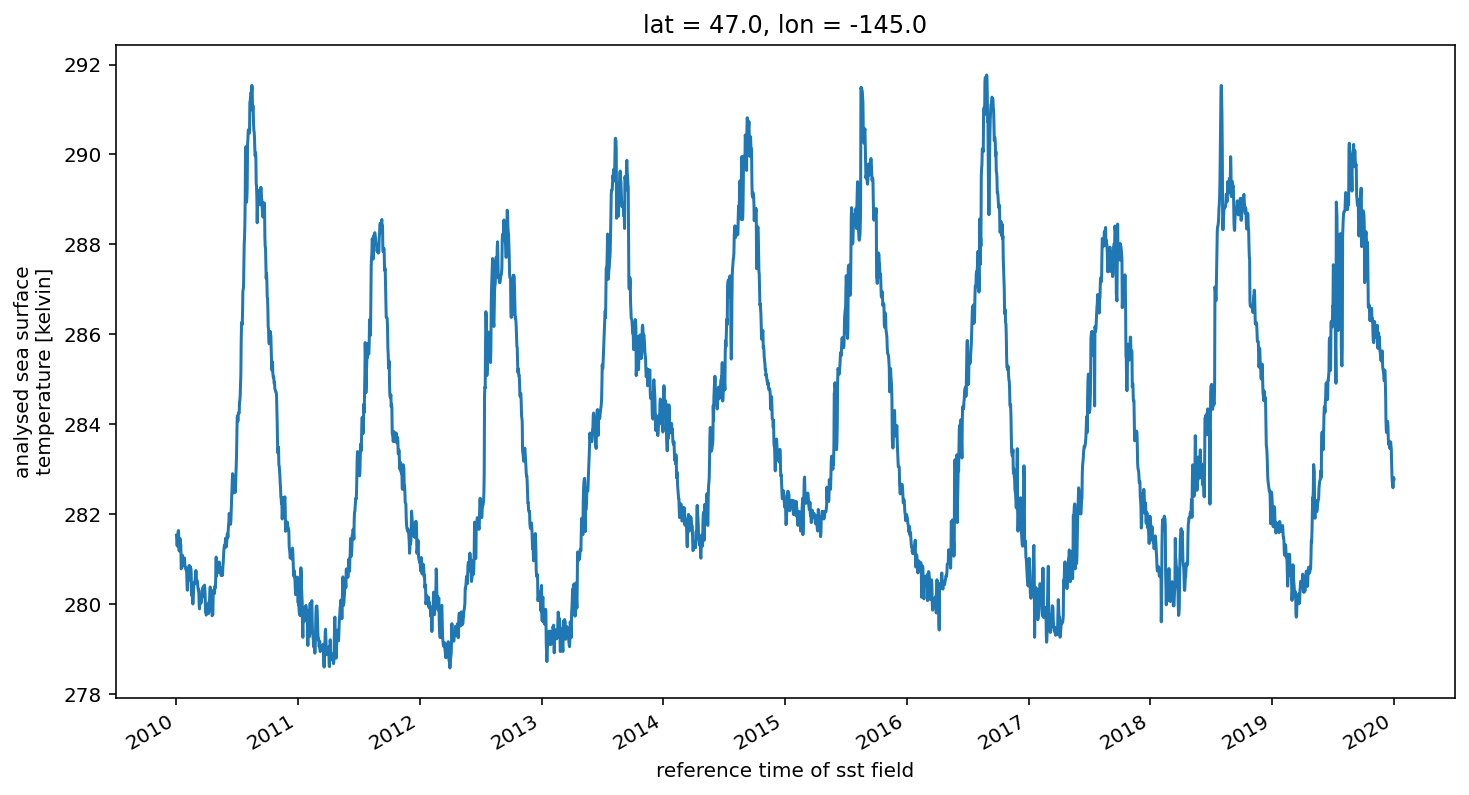

In [3]:
%%time

sst_timeseries = ds_sst['analysed_sst'].sel(time = slice('2010-01-01','2020-01-01'),
                                            lat  = 47,
                                            lon  = -145
                                           ).load()

sst_timeseries.plot()

### The anomaly is more interesting...  

Use [.groupby](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.groupby.html#xarray-dataarray-groupby) method to calculate the climatology and [.resample](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.resample.html#xarray-dataset-resample) method to then average it into 1-month bins.
- [DataArray.mean](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.mean.html#xarray-dataarray-mean) arguments are important! Xarray uses metadata to plot, so keep_attrs is a nice feature.  Also, for SST there are regions with changing sea ice.  Setting skipna = False removes these regions. 

CPU times: user 398 ms, sys: 3.55 ms, total: 401 ms
Wall time: 401 ms


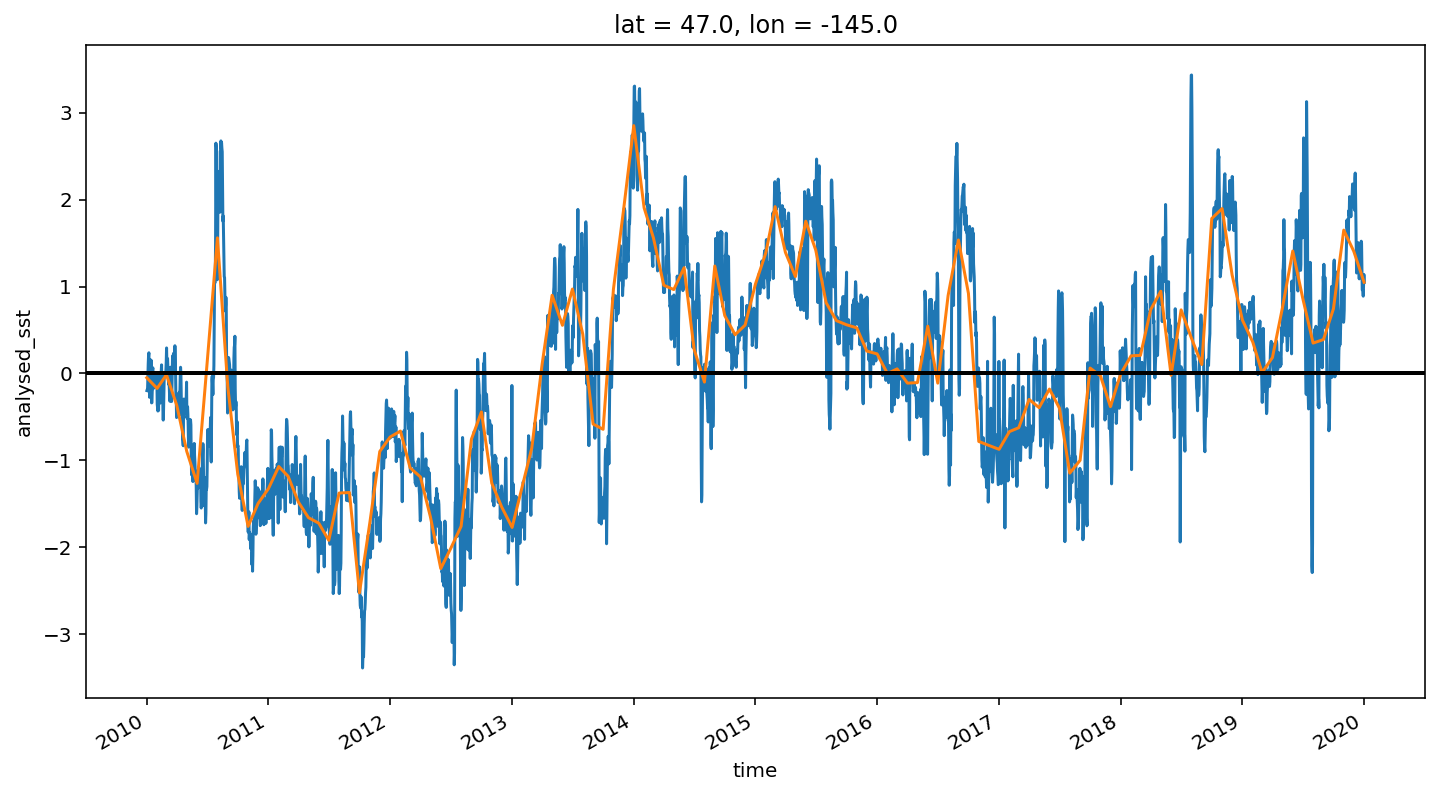

In [4]:
%%time

sst_climatology = sst_timeseries.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)

sst_anomaly = sst_timeseries.groupby('time.dayofyear')-sst_climatology

sst_anomaly_monthly = sst_anomaly.resample(time='1MS').mean(keep_attrs=True,skipna=False)

#plot the data
sst_anomaly.plot()
sst_anomaly_monthly.plot()
plt.axhline(linewidth=2,color='k')

# Chukchi Sea SST timeseries

# Note SST is set to -1.8 C (271.35 K) when ice is present

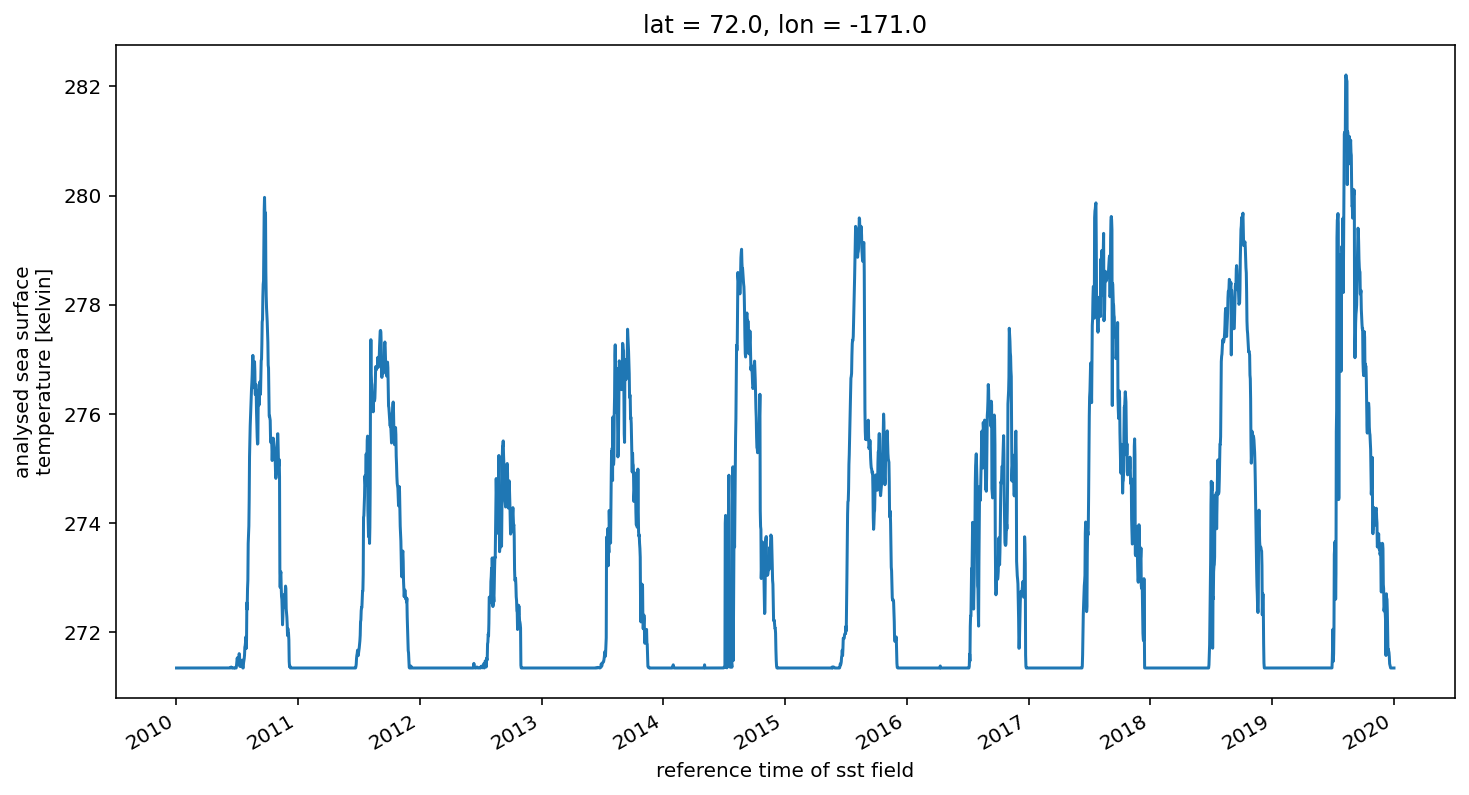

In [5]:
sst_timeseries = ds_sst['analysed_sst'].sel(time = slice('2010-01-01','2020-01-01'),
                                            lat  = 72,
                                            lon  = -171
                                           ).load()

sst_timeseries.plot()

# Grid resolution does NOT equal spatial resolution

- many L4 SST analyses blend infrared (~ 1 - 4 km data) with passive microwave (~ 50 km) data.  Data availability will determine regional / temporal changes in spatial resolution

- many L4 SST analyses apply smoothing filters that may further reduce resolution

CPU times: user 9.08 s, sys: 8.12 s, total: 17.2 s
Wall time: 20.9 s


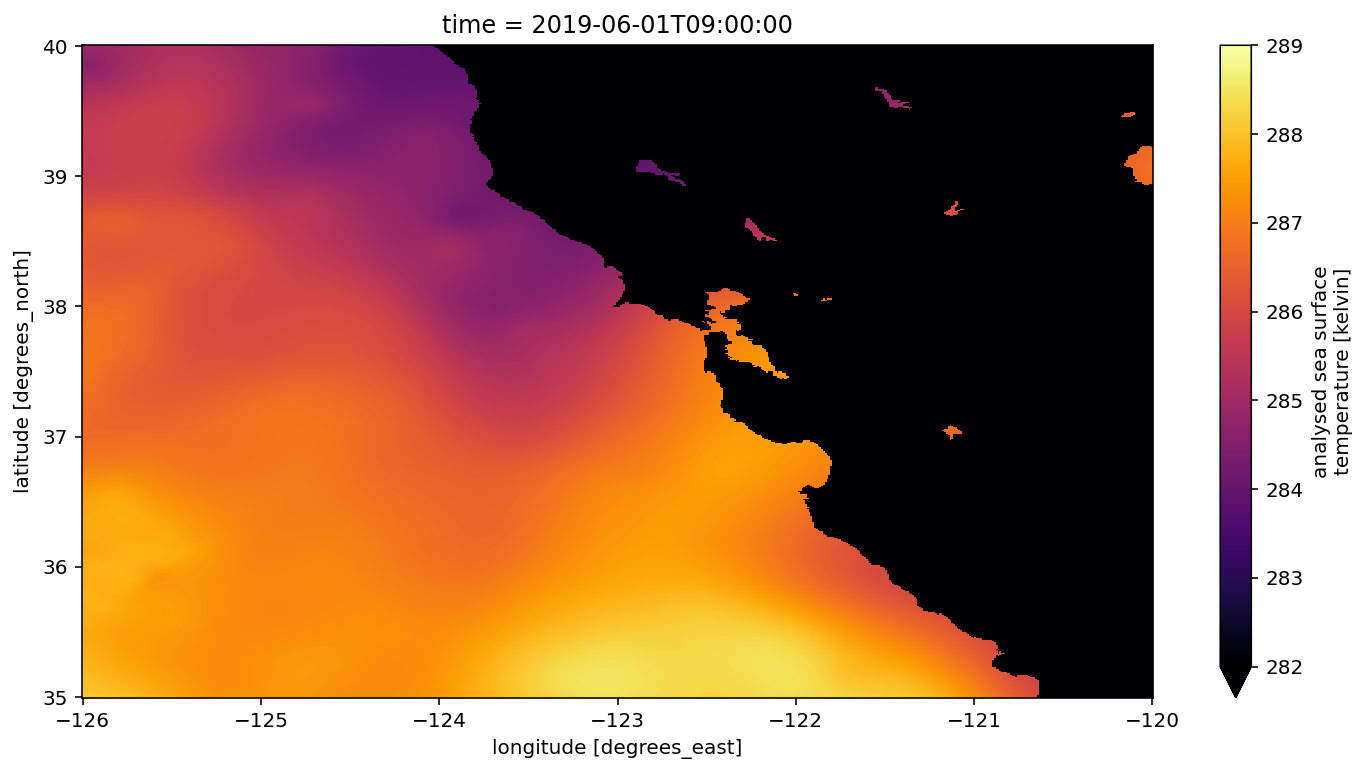

In [6]:
%%time

subset = ds_sst['analysed_sst'].sel(time='2019-06-01',lat=slice(35,40),lon=slice(-126,-120))

subset.plot(vmin=282,vmax=289,cmap='inferno')

CPU times: user 8.79 s, sys: 7.24 s, total: 16 s
Wall time: 11 s


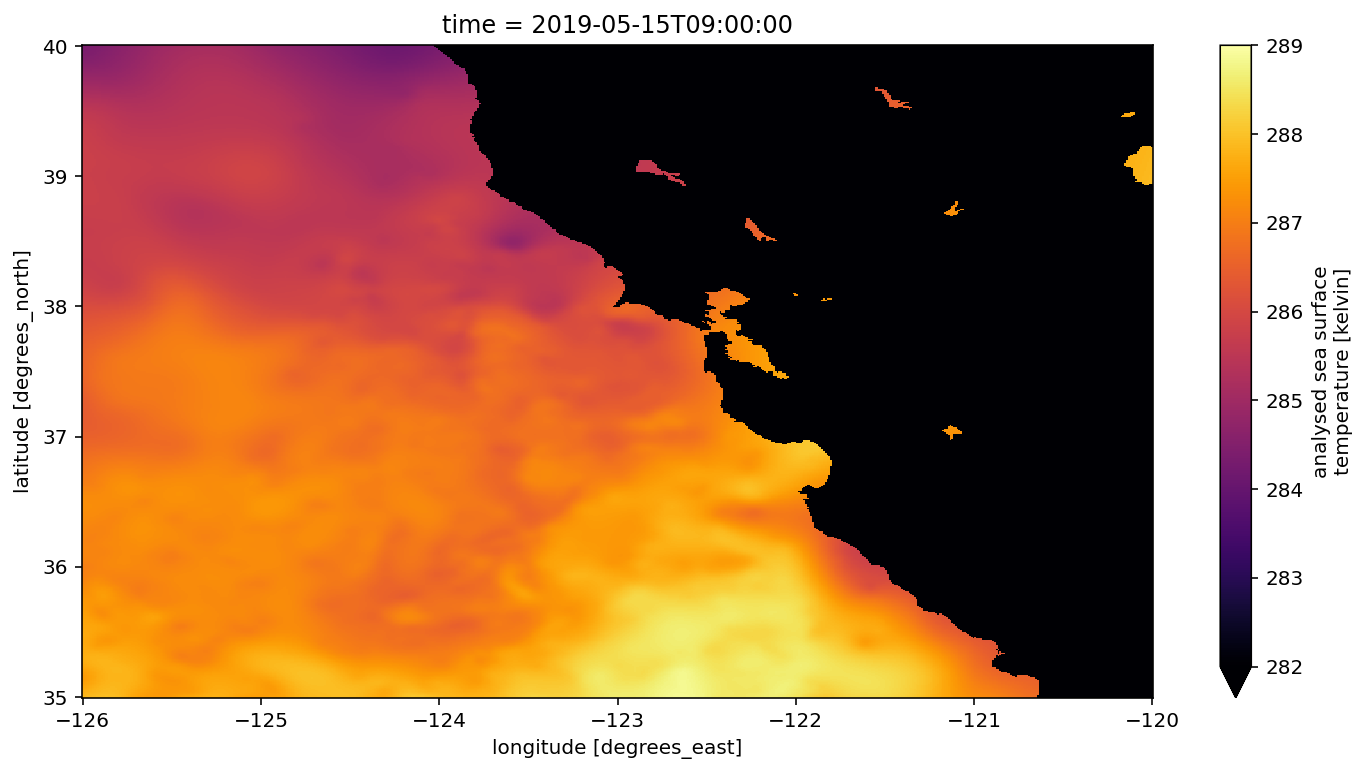

In [7]:
%%time

subset = ds_sst['analysed_sst'].sel(time='2019-05-15',lat=slice(35,40),lon=slice(-126,-120))

subset.plot(vmin=282,vmax=289,cmap='inferno')

# How to find an AWS Public Dataset

- click here: [AWS Public Dataset](https://aws.amazon.com/opendata/)


- Click on `Find public available data on AWS` button
- Search for GOES
- Select [GOES-16 and GOES-17](https://registry.opendata.aws/noaa-goes/)
![](./aws.png)


## NETCDF GEO DATA

## Zarr made it seem so easy to read and access cloud SST data! 
## It is always that easy, right?

- When data is just dumped on the cloud, it is still useful, but can be challenging to use.  
Which brings us to GOES SSTs.....

- Info on the data is here -- GOES has a lot of different parameters and they are all stored in different files with names that are difficult to understand.  There are *80* different data products.  This link lists them all and explains the different directory names. [AWS info on GOES SST data](https://docs.opendata.aws/noaa-goes16/cics-readme.html).  

- The GOES data is netCDF format.  There is a different for each of the 80 projects for year/day/hour.  A lot of files.  I find it really useful to 'browse' s3: buckets so that I can understand the directory and data structure.  [Explore S3 structure](https://noaa-goes16.s3.amazonaws.com/index.html).  The directory structure is `<Product>/<Year>/<Day of Year>/<Hour>/<Filename>`

- In the code below we are going to create a function that searches for all files from a certain day, then creates the keys to opening them.  The files are so messy that opening a day takes a little while.  There are other ways you could write this function depending on what your analysis goals are, this is just one way to get some data in a reasonable amount of time. 
- This function uses 
- [`s3fs.S3FileSystem`](https://s3fs.readthedocs.io/en/latest/) which holds a connection with a s3 bucket and allows you to list files, etc.  
- [`xr.open_mfdataset`](http://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html#xarray.open_mfdataset) opens a list of filenames and concatenates the data along the specified dimensions  

Website [https://registry.opendata.aws/noaa-goes/](https://registry.opendata.aws/noaa-goes/)


In [8]:
@dask.delayed
def get_geo_data(sat,lyr,idyjl):
    # arguments
    # sat   goes-east,goes-west,himawari
    # lyr   year
    # idyjl day of year
    
    d = dt.datetime(lyr,1,1) + dt.timedelta(days=idyjl)
    fs = s3fs.S3FileSystem(anon=True) #connect to s3 bucket!

    #create strings for the year and julian day
    imon,idym=d.month,d.day
    syr,sjdy,smon,sdym = str(lyr).zfill(4),str(idyjl).zfill(3),str(imon).zfill(2),str(idym).zfill(2)
    
    #use glob to list all the files in the directory
    if sat=='goes-east':
        file_location,var = fs.glob('s3://noaa-goes16/ABI-L2-SSTF/'+syr+'/'+sjdy+'/*/*.nc'),'SST'
    if sat=='goes-west':
        file_location,var = fs.glob('s3://noaa-goes17/ABI-L2-SSTF/'+syr+'/'+sjdy+'/*/*.nc'),'SST'
    if sat=='himawari':
        file_location,var = fs.glob('s3://noaa-himawari8/AHI-L2-FLDK-SST/'+syr+'/'+smon+'/'+sdym+'/*/*L2P*.nc'),'sea_surface_temperature'
    
    #make a list of links to the file keys
    if len(file_location)<1:
        return file_ob
    file_ob = [fs.open(file) for file in file_location]        #open connection to files
    
    #open all the day's data
    ds = xr.open_mfdataset(file_ob,combine='nested',concat_dim='time') #note file is super messed up formatting
    
    #clean up coordinates which are a MESS in GOES
    #rename one of the coordinates that doesn't match a dim & should
    if not sat=='himawari':
        ds = ds.rename({'t':'time'})
        ds = ds.reset_coords()
    else:
        ds = ds.rename({'ni':'x','nj':'y'})
    
    #put in to Celsius
    #ds[var] -= 273.15   #nice python shortcut to +- from itself a-=273.15 is the same as a=a-273.15
    #ds[var].attrs['units'] = '$^\circ$C'
   
    return ds


## Open a day of GOES-16  (East Coast) Data

In [9]:
%%time
lyr, idyjl = 2020, 210  #may 30, 2020

ds = dask.delayed(get_geo_data)('goes-east',lyr,idyjl)

ds

CPU times: user 163 µs, sys: 112 µs, total: 275 µs
Wall time: 251 µs


Delayed('get_geo_data-9439aca7-7bb3-47b7-b787-8b35028b1af8')

CPU times: user 22.7 s, sys: 11 s, total: 33.7 s
Wall time: 5min 29s


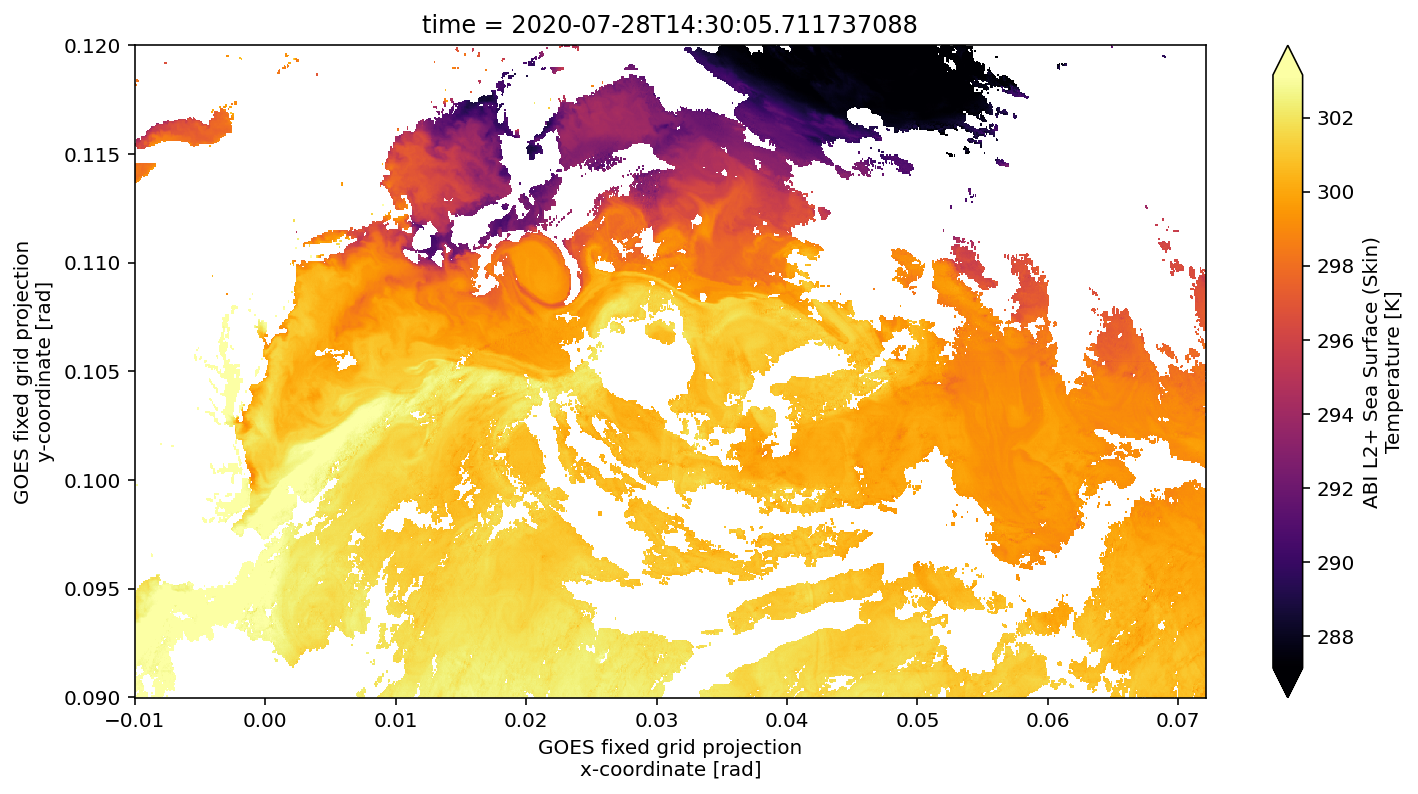

In [10]:
%%time
subset = ds.sel(x=slice(-0.01,0.07215601),y=slice(0.12,0.09))  #reduce to GS region

masked = subset.SST.where(subset.DQF==0).compute()

masked.isel(time=14).plot(vmin=14+273.15,vmax=30+273.15,cmap='inferno')

CPU times: user 2min 12s, sys: 1min 23s, total: 3min 35s
Wall time: 37min 2s


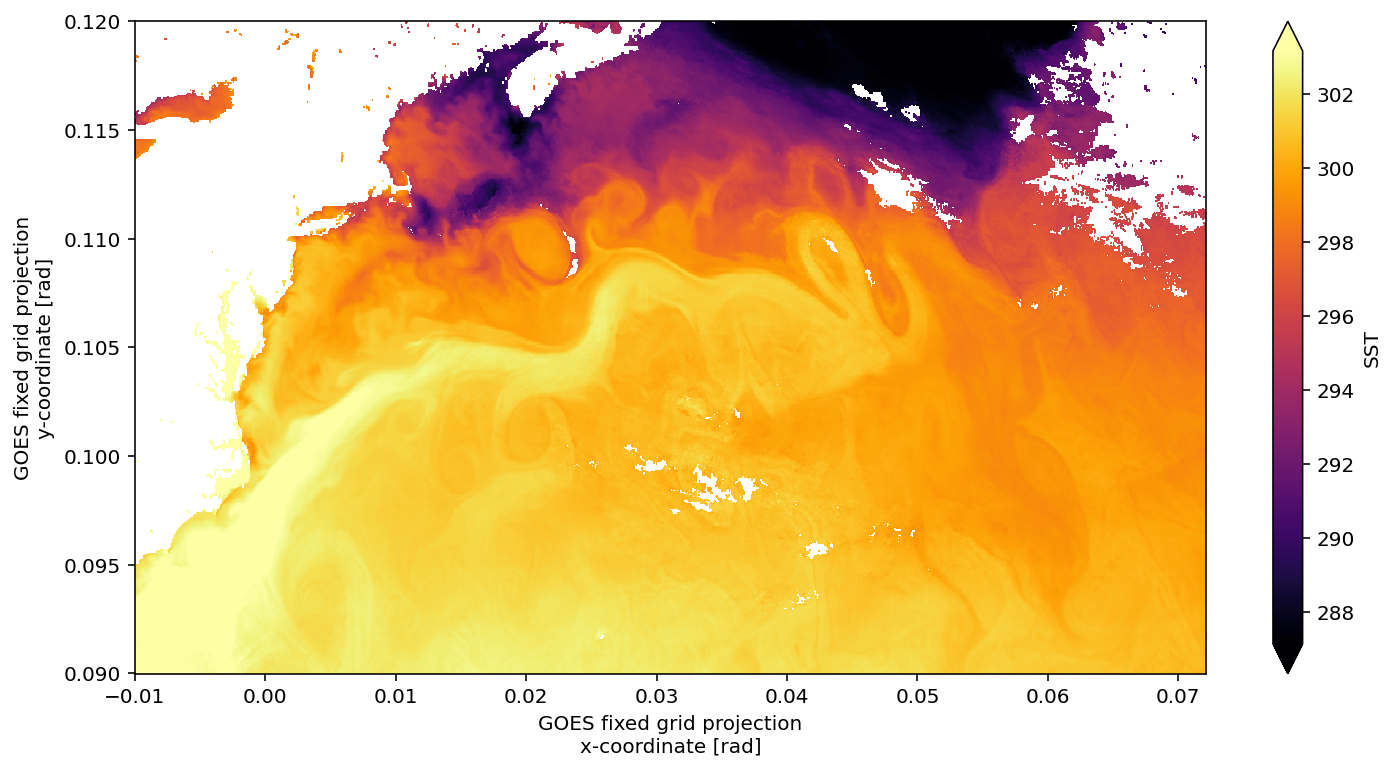

In [11]:
%%time

mean_dy = masked.mean('time',skipna=True).compute()   #here I want all possible values so skipna=True

mean_dy.plot(vmin=14+273.15,vmax=30+273.15,cmap='inferno')

## Lat/Lon
The data above is on the GOES grid, which isn't very helpful if you want to make a subset by a known lat/lon or to plot borders with Cartopy.

The function below takes in a GOES-16/17 dataset and returns the same dataset with latitude (`lat`) and longitude (`lon`) added as 2D coordinate arrays. The math to do this was taken from https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm 

In [12]:
def calc_latlon(ds):
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"

    return ds

In [13]:
ds_latlon = calc_latlon(ds.compute())

ds_latlon

<xarray.Dataset>
Dimensions:                                                 (SST_day_night_emissive_bands: 4, SST_night_only_emissive_band: 1, number_of_LZA_bounds: 2, number_of_SZA_bounds: 2, number_of_image_bounds: 2, number_of_time_bounds: 2, time: 24, x: 5424, y: 5424)
Coordinates:
  * time                                                    (time) datetime64[ns] ...
  * y                                                       (y) float32 0.151...
  * x                                                       (x) float32 -0.15...
    lat                                                     (y, x) float64 na...
    lon                                                     (y, x) float64 na...
Dimensions without coordinates: SST_day_night_emissive_bands, SST_night_only_emissive_band, number_of_LZA_bounds, number_of_SZA_bounds, number_of_image_bounds, number_of_time_bounds
Data variables:
    SST                                                     (time, y, x) float32 dask.array<chunksize=(1, 5424, 5424), meta=np.ndarray>
    DQF                                                     (time, y, x) float32 dask.array<chunksize=(1, 5424, 5424), meta=np.ndarray>
    time_bounds                                             (time, number_of_time_bounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    goes_imager_projection                                  (time) int32 -214...
    y_image                                                 float32 0.0
    y_image_bounds                                          (time, number_of_image_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    x_image                                                 float32 0.0
    x_image_bounds                                          (time, number_of_image_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    nominal_satellite_subpoint_lat                          (time) float64 0....
    nominal_satellite_subpoint_lon                          (time) float64 -7...
    nominal_satellite_height                                (time) float64 3....
    geospatial_lat_lon_extent                               (time) float32 9....
    total_number_of_good_quality_ocean_pixels               (time) float64 3....
    total_number_of_degraded_quality_ocean_pixels           (time) float64 5....
    total_number_of_severely_degraded_quality_ocean_pixels  (time) float64 1....
    total_number_of_unprocessed_pixels                      (time) float64 1....
    number_of_day_SST_pixels                                (time) float64 7....
    number_of_night_SST_pixels                              (time) float64 2....
    number_of_twilight_SST_pixels                           (time) float64 1....
    sea_surface_temp_outlier_pixel_count                    (time) float64 1....
    minimum_sea_surface_temp                                (time) float64 19...
    maximum_sea_surface_temp                                (time) float64 31...
    mean_sea_surface_temp                                   (time) float64 28...
    standard_deviation_sea_surface_temp                     (time) float64 16...
    min_obs_modeled_diff_SST_night_only_emissive_band       (time) float64 -5...
    max_obs_modeled_diff_SST_night_only_emissive_band       (time) float64 5....
    mean_obs_modeled_diff_SST_night_only_emissive_band      (time) float64 -0...
    std_dev_obs_modeled_diff_SST_night_only_emissive_band   (time) float64 0....
    min_retrieved_Reynolds_SST_diff                         (time) float64 -3...
    max_retrieved_Reynolds_SST_diff                         (time) float64 14...
    mean_retrieved_Reynolds_SST_diff                        (time) float64 0....
    std_dev_retrieved_Reynolds_SST_diff                     (time) float64 0....
    algorithm_dynamic_input_data_container                  (time) int32 -214...
    processing_parm_version_container                       (time) int32 -214...
    algorithm_product_version_container                     

### It's really slow to use `.where()` to select data 
e.g. 
```python
subset = ds.where((ds.lon >= lon1) & (ds.lon <= lon2) & (ds.lat >= lat1) & (ds.lat <= lat2), drop=True)
```

Instead, we can create a function that will return the x/y min and max so we can continue to use `.isel()` to quickly select data.

_note: the `y` slice must be done as `slice(y2,y1)` since the y coordinate is decreasing, so the larger value must come first._

In [14]:
def get_xy_from_latlon(ds, lats, lons):
    lat1, lat2 = lats
    lon1, lon2 = lons

    lat = ds.lat.data
    lon = ds.lon.data
    
    x = ds.x.data
    y = ds.y.data
    
    x,y = np.meshgrid(x,y)
    
    x = x[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]
    y = y[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)] 
    
    return ((min(x), max(x)), (min(y), max(y)))

### Now that we have a min/max `x` and `y`, we can subset in the same was as above

In [38]:
lats = (31, 53)
lons = (-85, -56)

(x1,x2), (y1,y2) = get_xy_from_latlon(ds_latlon, lats, lons)
subset = ds_latlon.sel(x=slice(x1,x2), y=slice(y2,y1))

subset

<xarray.Dataset>
Dimensions:                                                 (SST_day_night_emissive_bands: 4, SST_night_only_emissive_band: 1, number_of_LZA_bounds: 2, number_of_SZA_bounds: 2, number_of_image_bounds: 2, number_of_time_bounds: 2, time: 24, x: 1315, y: 776)
Coordinates:
  * time                                                    (time) datetime64[ns] ...
  * y                                                       (y) float32 0.131...
  * x                                                       (x) float32 -0.02...
    lat                                                     (y, x) float64 53...
    lon                                                     (y, x) float64 -9...
Dimensions without coordinates: SST_day_night_emissive_bands, SST_night_only_emissive_band, number_of_LZA_bounds, number_of_SZA_bounds, number_of_image_bounds, number_of_time_bounds
Data variables:
    SST                                                     (time, y, x) float32 dask.array<chunksize=(1, 776, 1315), meta=np.ndarray>
    DQF                                                     (time, y, x) float32 dask.array<chunksize=(1, 776, 1315), meta=np.ndarray>
    time_bounds                                             (time, number_of_time_bounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    goes_imager_projection                                  (time) int32 -214...
    y_image                                                 float32 0.0
    y_image_bounds                                          (time, number_of_image_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    x_image                                                 float32 0.0
    x_image_bounds                                          (time, number_of_image_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    nominal_satellite_subpoint_lat                          (time) float64 0....
    nominal_satellite_subpoint_lon                          (time) float64 -7...
    nominal_satellite_height                                (time) float64 3....
    geospatial_lat_lon_extent                               (time) float32 9....
    total_number_of_good_quality_ocean_pixels               (time) float64 3....
    total_number_of_degraded_quality_ocean_pixels           (time) float64 5....
    total_number_of_severely_degraded_quality_ocean_pixels  (time) float64 1....
    total_number_of_unprocessed_pixels                      (time) float64 1....
    number_of_day_SST_pixels                                (time) float64 7....
    number_of_night_SST_pixels                              (time) float64 2....
    number_of_twilight_SST_pixels                           (time) float64 1....
    sea_surface_temp_outlier_pixel_count                    (time) float64 1....
    minimum_sea_surface_temp                                (time) float64 19...
    maximum_sea_surface_temp                                (time) float64 31...
    mean_sea_surface_temp                                   (time) float64 28...
    standard_deviation_sea_surface_temp                     (time) float64 16...
    min_obs_modeled_diff_SST_night_only_emissive_band       (time) float64 -5...
    max_obs_modeled_diff_SST_night_only_emissive_band       (time) float64 5....
    mean_obs_modeled_diff_SST_night_only_emissive_band      (time) float64 -0...
    std_dev_obs_modeled_diff_SST_night_only_emissive_band   (time) float64 0....
    min_retrieved_Reynolds_SST_diff                         (time) float64 -3...
    max_retrieved_Reynolds_SST_diff                         (time) float64 14...
    mean_retrieved_Reynolds_SST_diff                        (time) float64 0....
    std_dev_retrieved_Reynolds_SST_diff                     (time) float64 0....
    algorithm_dynamic_input_data_container                  (time) int32 -214...
    processing_parm_version_container                       (time) int32 -214...
    algorithm_product_version_container                     (ti

### To plot with Cartopy, an axis need to be set up with a projection. More info can be found at https://scitools.org.uk/cartopy/docs/latest/crs/projections.html 

CPU times: user 10.8 s, sys: 7.01 s, total: 17.8 s
Wall time: 2min 45s


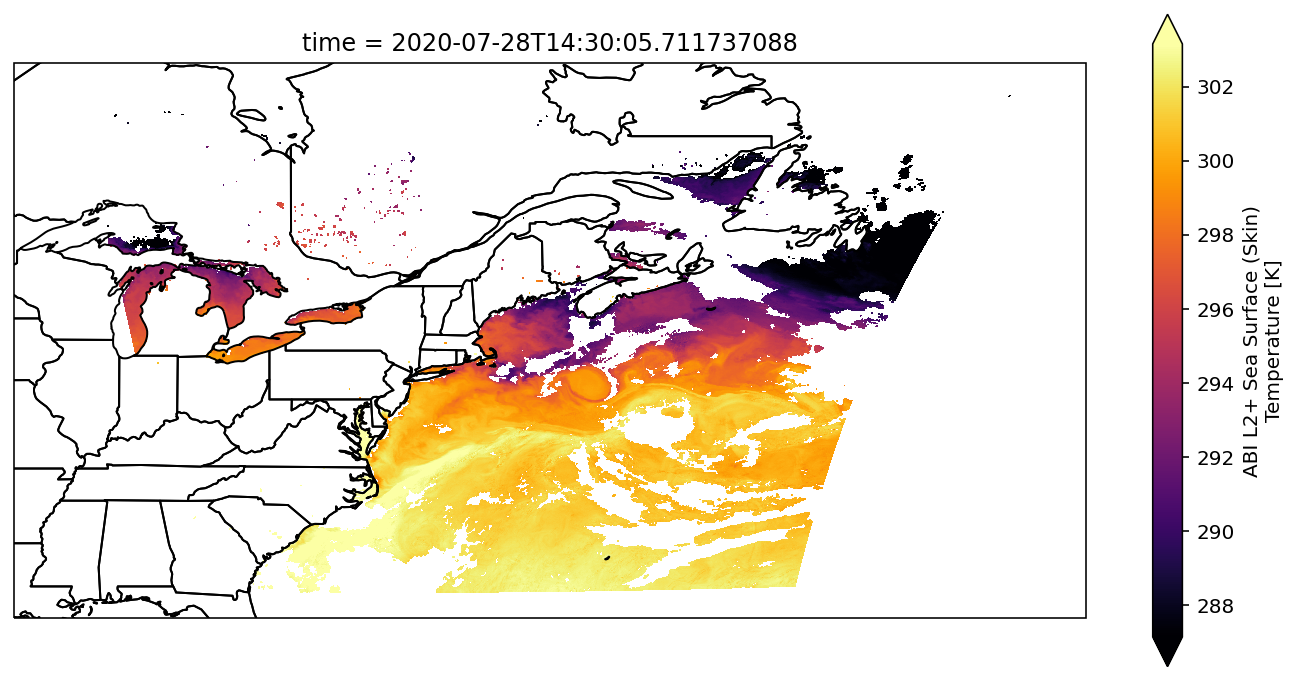

In [39]:
%%time
import cartopy.crs as ccrs
import cartopy.feature as cfeature

masked = subset.where(subset.DQF==0)


fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
masked.SST.isel(time=14).plot(x="lon", y="lat", vmin=14+273.15,vmax=30+273.15,cmap='inferno', ax=ax)

# For a longer running (but better looking) plot, take the mean instead of a single time
# masked.SST.mean("time", skipna=True).plot(x="lon", y="lat", vmin=14+273.15,vmax=30+273.15,cmap='inferno', ax=ax)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)

## Read AWS JMA Himawari SSTs
- define a function to get all the filenames for a day
- AWS info on Himawari SST data, [here](https://www.goes.noaa.gov/f_himawari-8.html)
- Explore S3 structure [here](https://noaa-himawari8.s3.amazonaws.com/index.html)
- SSTs are given in L2P and L3C GHRSST data formats.  
L2P has dims that not mapped to a regular grid.  
L3C is mapped to a grid, with dims lat,lon.

Website [https://registry.opendata.aws/noaa-himawari/](https://registry.opendata.aws/noaa-himawari/)


CPU times: user 28.3 s, sys: 16.8 s, total: 45.1 s
Wall time: 7min 5s


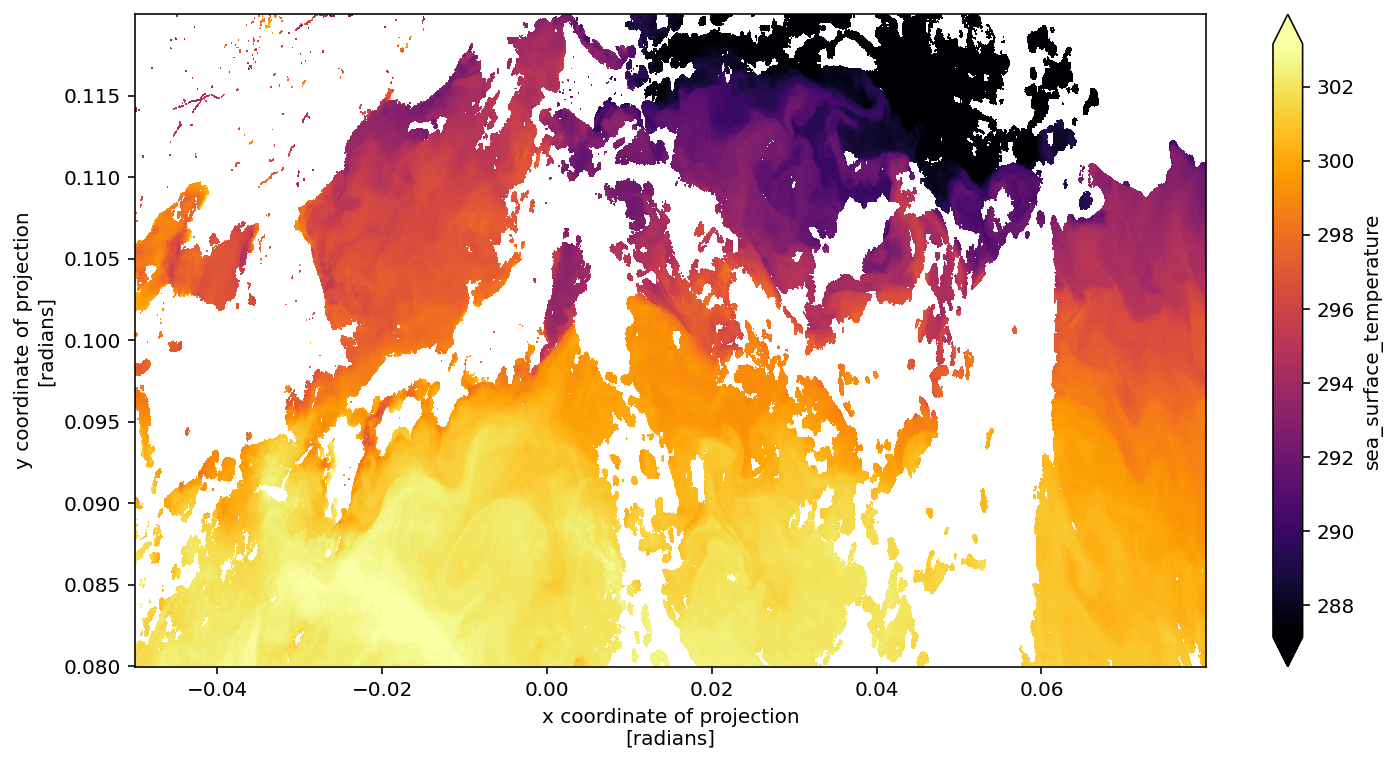

In [17]:
%%time
lyr, idyjl = 2020, 212

ds = dask.delayed(get_geo_data)('himawari',lyr,idyjl)

subset = ds.sel(x=slice(-0.05,0.08),y=slice(0.12,0.08))

masked = subset.sea_surface_temperature.where(subset.quality_level>=4)

mean_dy = masked.mean('time',skipna=True).compute()  #here I want all possible values so skipna=True

mean_dy.plot(vmin=14+273.15,vmax=30+273.15,cmap='inferno')

## ERA5 Data Structure on S3

The ERA5 data is organized into NetCDF files per variable, each containing a month of hourly data. 
The directory structure is `/{year}/{month}/main.nc` for all the variables or `/{year}/{month}/data/{var}.nc` for just a single variable.

Variables:
- snow_density
- sea_surface_temperature
- lwe_thickness_of_surface_snow_amount
- eastward_wind_at_10_metres
- northward_wind_at_10_metres
- time1_bounds
- air_temperature_at_2_metres_1hour_Maximum
- air_temperature_at_2_metres_1hour_Minimum
- precipitation_amount_1hour_Accumulation
- eastward_wind_at_100_metres
- air_temperature_at_2_metres
- dew_point_temperature_at_2_metres
- integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation
- northward_wind_at_100_metres
- air_pressure_at_mean_sea_level
- surface_air_pressure

For example, the full file path for sea surface temperature for January 2008 is:

/2008/01/data/sea_surface_temperature.nc

- Note that due to the nature of the ERA5 forecast timing, which is run twice daily at 06:00 and 18:00 UTC, the monthly data file begins with data from 07:00 on the first of the month and continues through 06:00 of the following month. We'll see this in the coordinate values of a data file we download later in the notebook.

- Granule variable structure and metadata attributes are stored in main.nc. This file contains coordinate and auxiliary variable data. This file is also annotated using NetCDF CF metadata conventions.


In [18]:
#https://nbviewer.jupyter.org/github/awslabs/amazon-asdi/blob/main/examples/dask/notebooks/era5_zarr.ipynb
# zac flamig


def fix_accum_var_dims(ds, var):
    # Some varibles like precip have extra time bounds varibles, we drop them here to allow merging with other variables
    
    # Select variable of interest (drops dims that are not linked to current variable)
    ds = ds[[var]]  

    if var in ['air_temperature_at_2_metres',
               'dew_point_temperature_at_2_metres',
               'air_pressure_at_mean_sea_level',
               'northward_wind_at_10_metres',
               'eastward_wind_at_10_metres']:
        
        ds = ds.rename({'time0':'valid_time_end_utc'})
        
    elif var in ['precipitation_amount_1hour_Accumulation',
                 'integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation']:
        
        ds = ds.rename({'time1':'valid_time_end_utc'})
        
    else:
        print("Warning, Haven't seen {var} varible yet! Time renaming might not work.".format(var=var))
        
    return ds

@dask.delayed
def s3open(path):
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False, 
                           config_kwargs = {'max_pool_connections': 20})
    return s3fs.S3Map(path, s3=fs)


def open_era5_range(start_year, end_year, variables):
    ''' Opens ERA5 monthly Zarr files in S3, given a start and end year (all months loaded) and a list of variables'''
    
    
    file_pattern = 'era5-pds/zarr/{year}/{month}/data/{var}.zarr/'
    
    years = list(np.arange(start_year, end_year+1, 1))
    months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
    
    l = []
    for var in variables:
        print(var)
        
        # Get files
        files_mapper = [s3open(file_pattern.format(year=year, month=month, var=var)) for year in years for month in months]
        
        # Look up correct time dimension by variable name
        if var in ['precipitation_amount_1hour_Accumulation']:
            concat_dim='time1'
        else:
            concat_dim='time0'
            
        # Lazy load
        ds = xr.open_mfdataset(files_mapper, engine='zarr', 
                               concat_dim=concat_dim, combine='nested', 
                               coords='minimal', compat='override', parallel=True)
        
        # Fix dimension names
        ds = fix_accum_var_dims(ds, var)
        l.append(ds)
        
    ds_out = xr.merge(l)
    
    return ds_out


In [19]:
%%time
ds = open_era5_range(2018, 2020, ["sea_surface_temperature"])

ds

sea_surface_temperature
Warning, Haven't seen sea_surface_temperature varible yet! Time renaming might not work.
CPU times: user 5.44 s, sys: 428 ms, total: 5.87 s
Wall time: 51.1 s


<xarray.Dataset>
Dimensions:                  (lat: 721, lon: 1440, time0: 26304)
Coordinates:
  * lat                      (lat) float32 90.0 89.75 89.5 ... -89.75 -90.0
  * lon                      (lon) float32 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * time0                    (time0) datetime64[ns] 2018-01-01 ... 2020-12-31...
Data variables:
    sea_surface_temperature  (time0, lat, lon) float32 dask.array<chunksize=(372, 150, 150), meta=np.ndarray>

CPU times: user 2.88 s, sys: 807 ms, total: 3.68 s
Wall time: 12.6 s


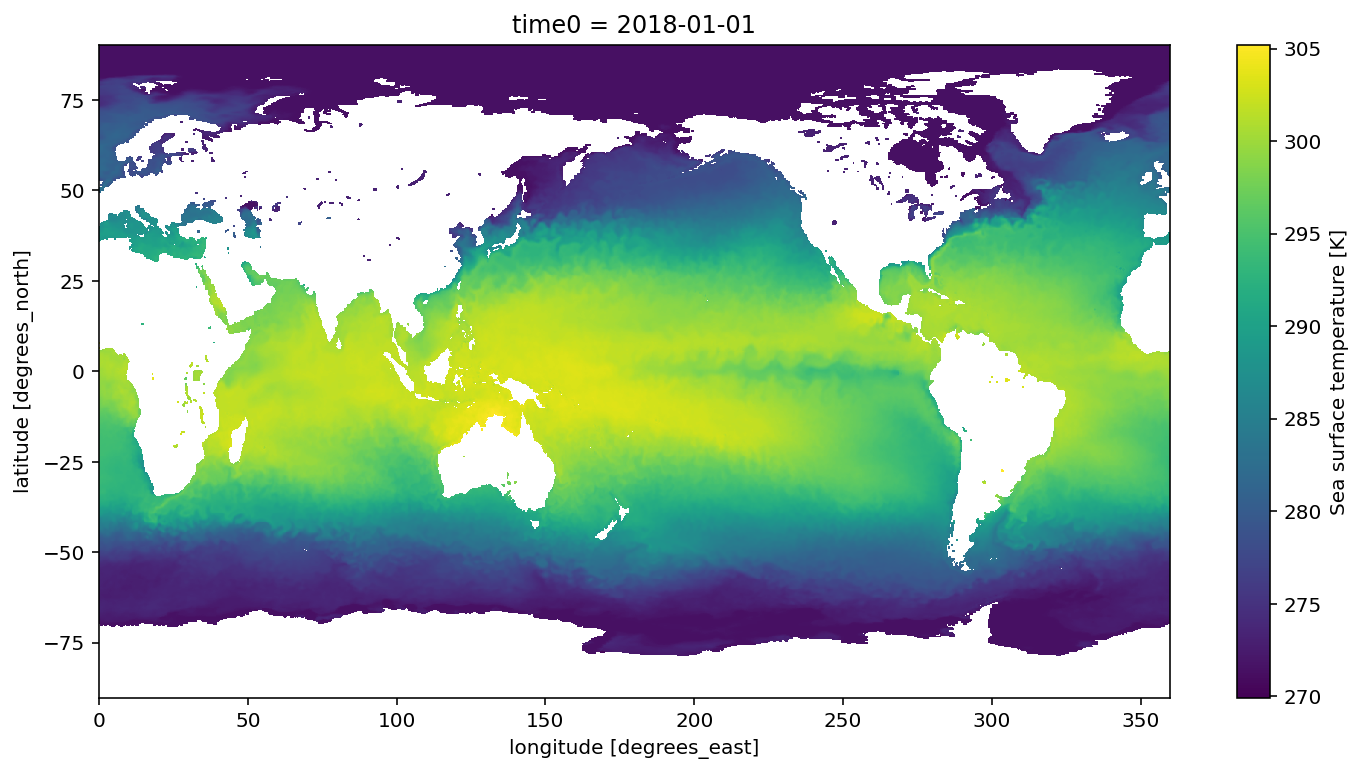

In [20]:
%%time

ds.sea_surface_temperature[0,:,:].plot()

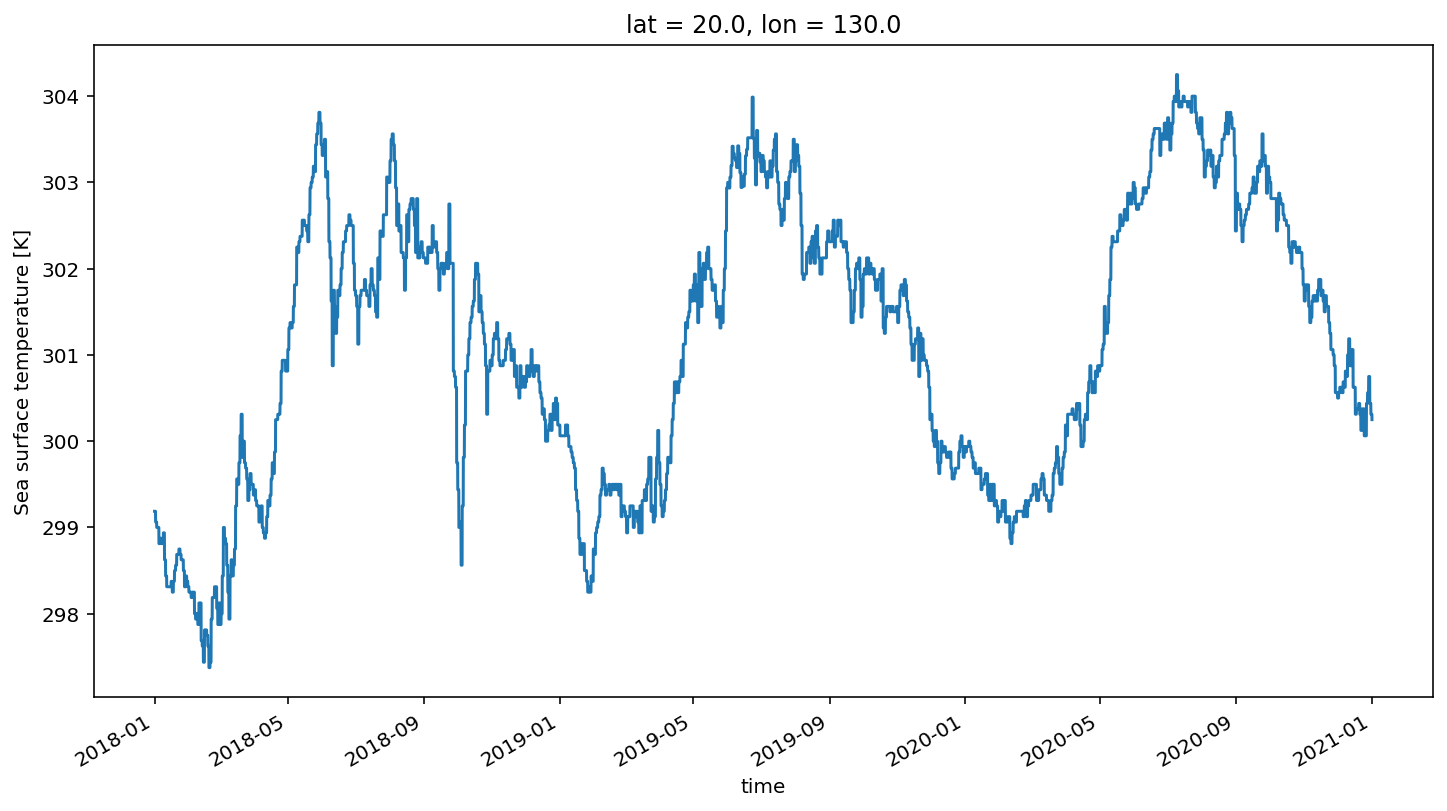

In [21]:
ds.sea_surface_temperature.sel(lon=130,lat=20).plot()